# Modelling Spatial Deer Distribution using Python

This notebook contains **Python code** and exercises associated with concepts discussed in lecture and [Millington _et al._ (2010)](http://dx.doi.org/10.1016/j.foreco.2009.12). The notebook _Modelling Spatial Deer Distribution using R_ provides the same examples but using R code. Compare the two notebooks to understand how the languages differ.

In [1]:
import pandas as pd               #for data
import seaborn as sns             #for plotting
import matplotlib.pyplot as plt   #for plotting
import statsmodels.api as sm      #for regression modelling
from scipy import stats           #for kendal tau
from sklearn import linear_model  #for cross-validation
from sklearn import model_selection
import numpy as np                #for mean and variance 
import numpy.ma as ma             #for masked array
import rasterio                   #for reading raster data
from rasterio.plot import show    #for plotting raster data

## Section 1: Loading and Checking Data

In [2]:
LOI200 = pd.read_csv("LOI200.csv") #read the file to a data.frame (assumes data are in same directory as notebook)

Now view the first few lines of the data:

In [3]:
LOI200.head()                                 #view the first part of the data (to check it read properly)

,Site,logDD,DistanceLC,NewDBH,NewBA,SnowDepth,LCProp,Ecoregion,AspenProp,HdwdProp,LCProp.1,CountStands
0,2,1.72,0.158,19.9,19.3,238,0.09,1,0.0,0.77,0.09,5
1,3,1.01,0.301,26.8,13.8,223,0.00,1,0.0,1.00,0.00,1
2,4,0.98,0.240,29.5,19.0,163,0.00,1,0.0,1.00,0.00,1
3,5,1.24,0.250,28.5,14.0,176,0.00,1,0.0,1.00,0.00,1
4,6,1.08,0.121,25.6,18.1,152,0.08,1,0.0,0.92,0.08,5


And see a summary of the variables in the data file:

In [4]:
LOI200.describe()                              #view a summary of the data

,Site,logDD,DistanceLC,NewDBH,NewBA,SnowDepth,LCProp,Ecoregion,AspenProp,HdwdProp,LCProp.1,CountStands
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,1840.686275,1.149804,0.285392,24.323529,21.296078,248.411765,0.037843,2.000000,0.123529,0.791373,0.037843,3.627451
std,1958.204478,0.362626,0.185569,4.864343,3.708798,56.621260,0.097597,1.216553,0.173687,0.220273,0.097597,2.097244
min,2.000000,0.330000,0.010000,13.800000,13.800000,152.000000,0.000000,1.000000,0.000000,0.190000,0.000000,1.000000
25%,29.500000,0.920000,0.163000,21.300000,18.600000,205.500000,0.000000,1.000000,0.000000,0.680000,0.000000,2.000000
50%,837.000000,1.170000,0.233000,24.900000,20.900000,233.000000,0.000000,1.000000,0.020000,0.850000,0.000000,3.000000
75%,4142.000000,1.395000,0.355500,27.150000,23.450000,299.000000,0.015000,3.000000,0.200000,0.985000,0.015000,5.000000
max,5342.000000,1.810000,0.930000,34.500000,29.200000,372.000000,0.460000,4.000000,0.720000,1.000000,0.460000,9.000000


Then we use some simple plotting functions to visualise the data:

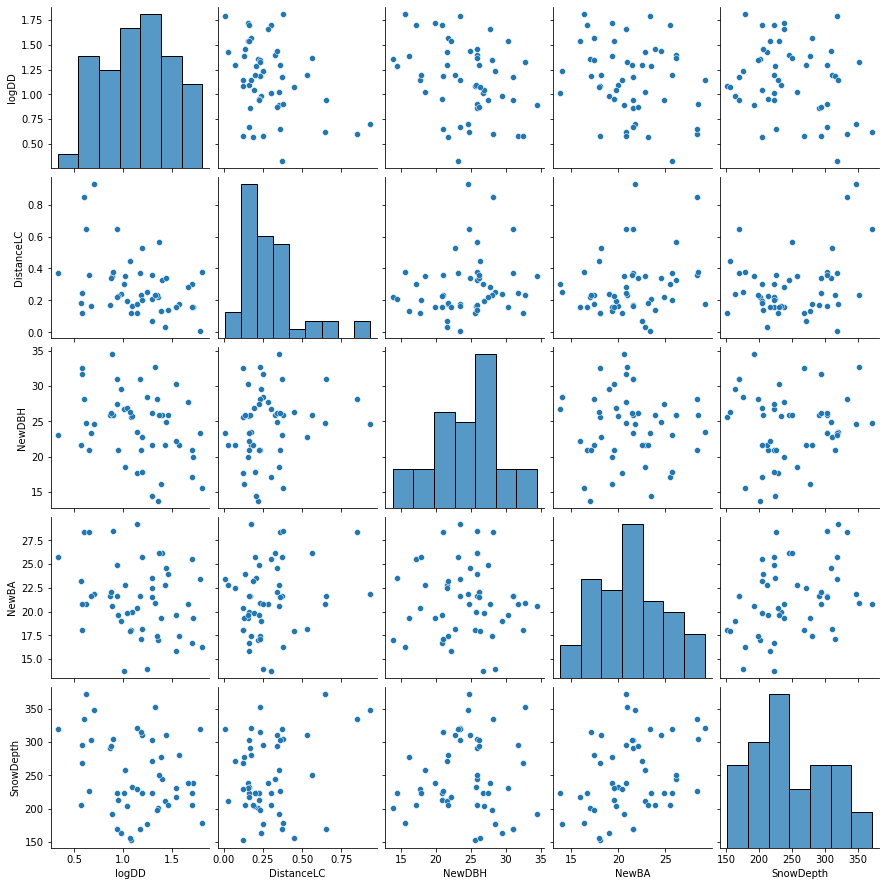

In [5]:
#matrix scatter plot for 2nd to 6th columns (python is 0 indexed!)
#no built-in function so use seaborn 
sns.pairplot(LOI200.iloc[:,1:6])    

Text(0, 0.5, 'log(Deer Density)')

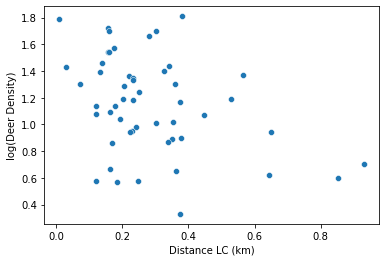

In [6]:
#seaborn scatter with axis labels
sns.scatterplot(data=LOI200, x='DistanceLC', y='logDD')
plt.xlabel("Distance LC (km)")
plt.ylabel("log(Deer Density)")        

## Section 2: Correlation and Simple Linear Regression

Now that we have familiarised ourselves with the data, we can do some simple correlations to examine the relationship of deer density with the distance to the nearest lowland conifer stand.  

In [7]:
print(LOI200[['DistanceLC','logDD']].corr(method='pearson')) #calculate pearson correlation coefficient (r)
print(LOI200[['DistanceLC','logDD']].corr(method='kendall')) #calculate kendall's correlation coefficient (tau)

            DistanceLC     logDD
DistanceLC    1.000000 -0.371427
logDD        -0.371427  1.000000
            DistanceLC     logDD
DistanceLC    1.000000 -0.211978
logDD        -0.211978  1.000000


We find some weak correlations (pandas does not give us an indication of statistical significance). 

The next piece of analysis we will do is to fit simple linear regression models to predict log(deer density) from environmental co-variates.

We could use `linear_model` from the `sklearn` package to fit our simple linear regression:

In [8]:
df_X = LOI200['DistanceLC']
df_y = LOI200['logDD']                  

new_df_X = df_X.values
new_df_X = new_df_X.reshape(-1,1)

#fit the model 
mod_dlc  = linear_model.LinearRegression()
mod_dlc .fit(new_df_X, df_y)

mod_dlc

LinearRegression()

However, there is no nice 'summary' method for `sklearn` `linear_model`s as there is in R. We can access model coefficients and intercept directly:

In [9]:
print(mod_dlc.intercept_)
print(mod_dlc.coef_)

1.3569464107166036
[-0.72581704]


But really this approach seems more suited to working with other computational tools for things like cross-validation (as we'll see below). For more straight-forward model fitting and analysis, we can use functions available in the `statsmodels` package. Read the docs and more detail [here](https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html). Specifically we can use the `OLS` function from the `statsmodels.api`. 

Using the `OLS` function from `statsmodels` to fit a regression requires we create an `OLS` object first, then use the `fit` [method](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit.html) on that object to create a `RegressionResults` [object](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html#statsmodels.regression.linear_model.RegressionResults). An easy way to create an `OLS` object is to use the `from_formula` [method](https://www.statsmodels.org/dev/dev/generated/statsmodels.base.model.Model.from_formula.html?highlight=from_formula#statsmodels.base.model.Model.from_formula) to pass the equation of the model we want to fit (as well as indicating what the data are that we are using):

In [10]:
#requires import statsmodels.api as sm
mod_dlc = sm.OLS.from_formula("logDD ~ DistanceLC", data = LOI200) 
mod_dlc_RR = mod_dlc.fit()
print(mod_dlc_RR.summary())

                            OLS Regression Results                            
Dep. Variable:                  logDD   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     7.842
Date:                Wed, 11 Nov 2020   Prob (F-statistic):            0.00729
Time:                        16:34:31   Log-Likelihood:                -16.342
No. Observations:                  51   AIC:                             36.68
Df Residuals:                      49   BIC:                             40.55
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3569      0.088     15.424      0.0

Let's see how this model looks using a scatter plot of the variables - seaborn will fit a regression with confidence envelope for us (but note we have less control than in R)

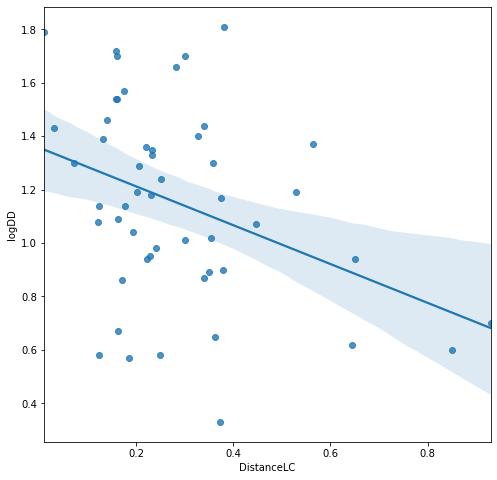

In [11]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.regplot(x=LOI200.DistanceLC, y=LOI200.logDD) 

From the [statsmodel docs](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html) we can see that we can access the model residuals using `.resid`. We can use this to plot our own histogram of model residuals, for example:

<AxesSubplot:>

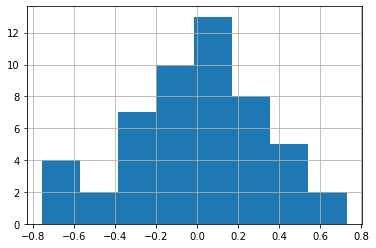

In [12]:
mod_dlc_RR.resid.hist(bins=8)           

This plot shows that the residuals are reasonably normally distributed and that we are likely not violating the assumptions of simple linear regression. 

R provides built-in diagnostic plotting functions for regression model objects. `statsmodels` in python doesn't offer this, but there are [relatively straight-forward ways to run diagnostics](https://www.statsmodels.org/dev/examples/notebooks/generated/regression_diagnostics.html).   

To get some other useful model outputs, we need to get items from the model summary:

In [13]:
round(mod_dlc_RR.params,3)    #directly access the model coefficients 

Intercept     1.357
DistanceLC   -0.726
dtype: float64

In [14]:
round(mod_dlc_RR.rsquared,2)  #directly access the r.squared of the model

0.14

In [15]:
round(mod_dlc_RR.pvalues,3)

Intercept     0.000
DistanceLC    0.007
dtype: float64

The code in this section has provided all we need to know to calculate the values in the first row of Table 1 in Millington et al. (2010).

### Task 1.
Use the code above to help you calculate values for the four other variables in Table 1 that have p < 0.1. Check you can get values from your code that correspond to those in Table 1 of Millington _et al._ (2010) 

## Section 3. Multiple linear regression models
Fitting linear regression models with more than one are almost as straighforward as for simple (univariate) linear regression models. We just need to add the additional variables into the model equation:

In [16]:
mod_dlc_dbh = sm.OLS.from_formula("logDD ~ DistanceLC + NewDBH", data = LOI200) 
mod_dlc_dbh_RR = mod_dlc_dbh.fit()
print(mod_dlc_dbh_RR.summary())

                            OLS Regression Results                            
Dep. Variable:                  logDD   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     6.071
Date:                Wed, 11 Nov 2020   Prob (F-statistic):            0.00446
Time:                        16:34:33   Log-Likelihood:                -14.377
No. Observations:                  51   AIC:                             34.75
Df Residuals:                      48   BIC:                             40.55
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7960      0.240      7.493      0.0

To get a kendall correlation coefficient we need to output the predicted logDDs and then test using `kendalltau` from the [`stats` module of the `scipy` package](https://docs.scipy.org/doc/scipy/reference/stats.html):

In [17]:
mod_dlc_dbh_RR_pred  = mod_dlc_dbh_RR.predict()

In [18]:
#requires from scipy import stats 
stats.kendalltau(LOI200['logDD'], mod_dlc_dbh_RR_pred)

KendalltauResult(correlation=0.31144435727526765, pvalue=0.001294760740140621)

### Task 2.
Use the code above to write your own code to calculate the values in Table 2 of Millington _et al._ (2010) for the Full Model (all values except for cross-validation)

## Section 4. Cross-validation
To complete the bottom two lines of Table 2 in Millington et al. (2010) we need to run cross-validation. In python, we can use functionality from the [`sklearn` package](https://scikit-learn.org/stable/index.html) for [cross-validation](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6).

First, we need to fit the model again using `sklearn` to create a model object that it will be able handle:  

In [19]:
#requires from sklearn import linear_model

#create independent and dependent variables
df_X = LOI200[['DistanceLC','NewDBH']]  
df_y = LOI200['logDD']                  

#fit the mode 
mod_dlc_dbh = linear_model.LinearRegression()
mod_dlc_dbh.fit(df_X, df_y)

#we can get simple otuputs
print(mod_dlc_dbh.coef_)  #model coefficients
print(mod_dlc_dbh.score(df_X, df_y)) #r2

[-0.62426055 -0.01924293]
0.20188714479823788


We can use the fitted model to estimate predicted values for all out observations:

In [20]:
Predicted = mod_dlc_dbh.predict(df_X)
print(Predicted)

[1.31445149 1.09240601 1.07852999 1.09153031 1.22786442 1.25861025
 1.39375348 1.40188111 1.26920179 1.29333578 1.10983992 1.21966079
 0.7221226  0.74208057 1.02704633 1.24771325 1.1977969  1.15727759
 0.91364667 1.25151032 1.11432501 1.36164386 1.19150278 1.3903231
 1.33604918 1.02132243 1.09411813 1.23331599 1.16655937 1.33949179
 1.06103232 1.13017683 0.91614624 0.94554412 1.26358344 1.21085486
 1.27906244 1.26894423 1.08694832 0.96601468 1.03120146 1.10462142
 1.11865809 1.08022987 1.37925932 1.24397993 1.01088543 0.79371877
 1.06836892 1.09446394 1.32739418]


To do a single 5-fold cross validation for the regression model we would use:

In [21]:
#requires from sklearn import model_selection
cvpred = model_selection.cross_val_predict(mod_dlc_dbh, df_X, df_y, cv=5)
print(cvpred)

[1.21845941 1.07065189 1.08371283 1.08650904 1.19039712 1.12197384
 1.23551624 1.26699575 1.19220936 1.20778265 1.10035765 1.26993502
 0.8013707  0.8502362  1.08343545 1.26781983 1.18497242 1.14390928
 0.88777447 1.27163901 1.07945954 1.34764318 1.17010758 1.43716028
 1.32688919 0.96953252 1.09114117 1.22610002 1.19497661 1.31311523
 1.06431283 1.12699046 0.88459536 0.92051468 1.25220456 1.20959541
 1.25281316 1.25981273 1.08094923 0.96084356 1.03434454 1.13706205
 1.14639201 1.11277709 1.44334528 1.3019885  1.02785548 0.78127893
 1.09817622 1.15812165 1.37994074]


This has created an array of predicted values based on models fit for each of the folds created (see `model_selection.KFold` for [more](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html?highlight=kfold#sklearn.model_selection.KFold) on how the folds are created). 

Now append the predictors (from both all observations and the cross-validation) to the original data to allow us to calculate correlations for comparing between using all observed data vs k-folds:

In [22]:
CVdata = LOI200
CVdata['Predicted'] = Predicted
CVdata['cvpred'] = cvpred

#Predicted
r = CVdata['logDD'].corr(CVdata['Predicted'])
r2 = r**2
t = CVdata['logDD'].corr(CVdata['Predicted'], method='kendall')
    
print("r2 (obs): ", round(r2,3))   
print("tau (obs): ", round(t,3))
print('\n')

#Cross Validated
r = CVdata['logDD'].corr(CVdata['cvpred'])
r2 = r**2
t = CVdata['logDD'].corr(CVdata['cvpred'], method='kendall')
    
print("r2 (cv): ", round(r2,3))   
print("tau (cv): ", round(t,3))

r2 (obs):  0.202
tau (obs):  0.311


r2 (cv):  0.089
tau (cv):  0.181


But note how the caption of Table 2 indicates that 
>"estimates for cross-validation results are 95% confidence intervals calculated from mean and variance of 100 repetitions." 

To do this we need to create a loop to run the cross-validation multiple times, storing the results so we can calculate the mean
and variance:

In [23]:
cv_r2 = []
cv_tau = []

for i in range(100):

    kf = model_selection.KFold(n_splits=5,shuffle=True, random_state=i)  #needed to create random folds (using i)
    cvpred = model_selection.cross_val_predict(mod_dlc_dbh, df_X, df_y, cv=kf)  #predict using current random folds
    
    #correlations
    r = LOI200['logDD'].corr(pd.Series(cvpred))
    tau = LOI200['logDD'].corr(pd.Series(cvpred), method='kendall')
    
    #append to list
    cv_r2.append(r**2)
    cv_tau.append(tau)
  

Now we can calculate mean and variance for r2 and tau

In [24]:
print(np.mean(cv_r2))
print(np.mean(cv_tau))
print(1.96 * np.var(cv_r2))  
print(1.96 * np.var(cv_tau))

#printoptions precision does not work for numpy.float64! 
#see https://stackoverflow.com/questions/47637972/numpy-set-printoptions-precision-ignored-in-list-of-tuples

0.11282454846579283
0.21431461453916778
0.0018006481871323046
0.0026672948598997956


### Task 3.

Build on the code above to calculate the cross-validation values for the 'Full' model

## Section 5. Spatial Estimation
Later in Millington _et al._ (2010) models fit from the sample data (at 51 locations) were used to predict deer density across a subsection of the study area. We readily do this in R using the functionality in the `raster` package. Things are not so straight-forward in python because the raster processing tools do not seem to be so well developed... 

In python, the main package for raster tools seems to be [`rasterio`](https://rasterio.readthedocs.io/). However, the rasterio package doesn't have predict methods like for R and to do what we want to do here, [others have suggested simply using R!](https://stackoverflow.com/questions/48853484/how-to-structure-data-for-prediction-using-rasters-as-targets). As its name suggests, rasterio is focused on raster input and output.  

After some exploring, I thought we might be able use [pyimpute](https://github.com/perrygeo/pyimpute) which has some nice features and contains a lot of the functionality we want._But_ pyimpute assumes the data used to fit models are from the study rasters themselves (indicated by points within the raster). In the current situation, we have already fit the model using point data and now simply want to apply the fitted model parameters to our explanatory rasters.

Further googling suggested we could use `numpy arrays` with the numpy predict methods, for example see [here](https://stackoverflow.com/questions/29036179/what-is-the-python-equivalent-to-r-predict-function-for-linear-models) and [here](https://www.statsmodels.org/devel/examples/notebooks/generated/predict.html). We would have to do some fiddling moving back and forth between 1D arrays and 2D rasters but it should be possible. To specify the point location values we will need to use [numpy masked arrays](https://numpy.org/doc/stable/reference/maskedarray.generic.html) (e.g. see [here](https://stackoverflow.com/a/38856546) and [here](https://stackoverflow.com/a/38194439)).

First, we'll do a uni-variate model for distance to lowland conifer. Let's view the raster data we're going to use to predicte deer distribution (distance to lowland conifer).  

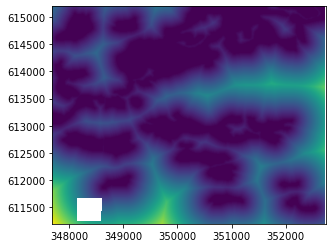

<AxesSubplot:>

In [25]:
#read the raster with rasterio,  requires import rasterio and from rasterio.plot import show
dlc_r = rasterio.open('LOI200_dlc_km.asc')
rasterio.plot.show(dlc_r)

Note the 'empty' block (no data) in the bottom left. This will be important in a minute...

Next, we create [a 1D `ndarray`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) from this 2D raster: 

In [26]:
#read the raster with rasterio,  requires import rasterio
#we need to use src.read for flatten() method below
with rasterio.open('LOI200_dlc_km.asc') as src:
    dlc_r = src.read(1)  
    
dlc_f = dlc_r.flatten()  #flatten from 2d to 1D

#check we have produced a 1D array
print(type(dlc_f))
print(dlc_f.shape)

<class 'numpy.ndarray'>
(202104,)


Now, remember that block of no data in the bottom left of the raster? We tell python to ignore this. We do that using a masked array:

In [27]:
#create the mask. requres import numpy.ma as ma
ma_dlc = ma.masked_values(dlc_f, -9999)   #specify that -9999 is no data 
mac_dlc = ma.compressed(ma_dlc)           #remove these no data values

We can use the `mod_dlc` sklearn linear model object we created above to make our predictions:

In [29]:
#fit the model 
mod_dlc  = linear_model.LinearRegression()
mod_dlc .fit(new_df_X, df_y)

res = mod_dlc.predict(dlc_f.reshape(-1,1))
res = res.astype(np.float32) #original were float32

Before we convert our 1D data back to 2D we need re-insert the no data values we removed:

In [30]:
pred_dlc = ma.MaskedArray(res, mask=ma_dlc.mask,fill_value=-9999)

And now we can convert back to a 2D map:

In [31]:
pred2D = pred_dlc.reshape(dlc_r.shape)

And plot!

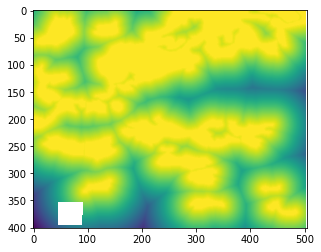

<AxesSubplot:>

In [32]:
rasterio.plot.show(pred2D)

Phew! What took a couple of lines in R, took a lot more work in python. And getting a legend on that plot will take [even more messing with matplotlib](https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib). We can at least just make the plot a little larger...  

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

im = ax.imshow(pred2D)

plt.show()

### Task 5.

Use code in this section to create a predicted deer density map for the 'best model' (i.e. using `LOI200_dlc_km.asc` and `LOI200_Meandbh_cm.asc` as predictor maps).